# A3 - Learn an XOR Neural Network using gradient-based optimization

This notebook shows some cool implementation and analyses of different neural network architectures to learn the X-OR function. The X-OR function is a good benchmark test for beginners in neural networks and deep learning because it is a non-linear function that can not be learnd by a simple linear model like linear regression that we have seen in the previous course a lot. 

Each of the models will be trained using gradient descent to minimize the loss function which in this case will be the mean squared error (MSE) between the predictions and true outputs.

For comparison, the models will also be implemented using TensorFlow and Keras.

This notebook will only cover chapter 1.2 which is a setup and 1.5 which is a implementation of of a Neural Networking using ReLu as an activation function and with some backpropagation.

## 1.2 Setting the scene

In this section, i will first import the required libraries for this assignment and also explain the X-OR function. I will also show the main "metric" that will be used which is MSE. In the example, MSE is implemented manually but i think there is a built-in function that does that but i will also show how to implement it manually just in case.

In [31]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

print("TensorFlow version:", tf.__version__) # verify that TF works

TensorFlow version: 2.19.0


In [32]:
def mse(ws, m, X, Y):
    N = len(X)
    err = 0
    for i in range(N):
        xi = X[i]
        yi = m(ws, xi)
        err += (Y[i] - yi) ** 2
    return err / N

# XOR input and output
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])
#Y = np.array([0, 1, 1, 0])
Y = np.array([[0], [1], [1], [0]])
# right after you load or define Y:     # maybe this is what you have now
#Y = Y.reshape(-1, 1)            # → shape (4,1)


print("XOR input:")
print(X)
print("XOR output:")
print(Y)

XOR input:
[[0 0]
 [0 1]
 [1 0]
 [1 1]]
XOR output:
[[0]
 [1]
 [1]
 [0]]


For this, i also choose to manually extract the data that i saw in the matlab and i will use this for the models.

In [33]:
# ─── 2) YOUR MATLAB WEIGHTS ────────────────────────────────────
# Hidden layer weights for x1 (w11) and x2 (w12), each length 32:
w11 = np.array([
    0.41652033,  0.7749157 ,  0.83778775,  0.64122725,  0.3972386 ,
   -0.13516521, -0.60432655, -0.20290181, -0.7232665 , -0.35317   ,
   -0.8889785 , -0.2863993 ,  0.54030126,  0.37175888, -0.82367843,
   -0.33497408, -0.8567182 ,  0.5161414 , -0.25462216,  0.59564906,
    0.80922335,  0.00252599,  0.3720131 , -0.1701207 ,  0.34805146,
   -0.38333094, -0.17244412,  0.7132528 , -0.14648864, -0.17876345,
   -0.6636416 , -0.39717668
], dtype=np.float32)

w12 = np.array([
    0.41662493, -0.7749062 , -0.8376726 , -0.64101034,  0.40976927,
   -0.09223783,  0.60428804, -0.09886253,  0.7417394 , -0.08979583,
    1.1194593 ,  0.13293397,  0.5400226 ,  0.37171456,  0.8246372 ,
   -0.43565178,  0.85677105,  0.51622313, -0.41895077, -0.5953253 ,
   -0.8091849 , -0.3766787 ,  0.28819063, -0.38122708,  0.34833792,
    0.15245543, -0.25060123, -0.7132655 , -0.30406952, -0.3443008 ,
    0.66343206, -0.03848529
], dtype=np.float32)

b1 = np.array([
   -4.16518986e-01, -4.11640503e-05, -1.45169579e-05, -3.96516771e-06,
   -1.09622735e-04,  0.00000000e+00,  2.90098578e-05,  0.00000000e+00,
   -1.63983065e-03,  0.00000000e+00, -6.36966957e-04, -1.47912502e-01,
   -5.39916575e-01, -3.71752203e-01, -5.50682598e-04,  1.15736163e+00,
   -6.27825721e-05, -5.16140461e-01,  0.00000000e+00, -1.62737619e-04,
   -8.02413124e-05, -2.25486048e-02,  1.79730232e-05,  0.00000000e+00,
   -3.48306417e-01, -1.66664287e-01,  0.00000000e+00, -3.03934885e-05,
    0.00000000e+00,  0.00000000e+00,  6.44910688e-05,  0.00000000e+00
], dtype=np.float32)

# Output‐layer weights+ bias, length 33: first 32 are hidden→output, last is b2
ws2 = np.array([
   -0.8178053 ,  1.0259871 ,  0.7672013 ,  0.9983522 ,  0.3300904 ,
    0.1318875 ,  0.9221373 ,  0.20387506,  1.0057546 ,  0.2067241 ,
    0.7479725 , -0.25578788, -0.83140665, -0.952559  ,  0.946334  ,
   -1.0112743 ,  0.5946371 , -1.0230583 , -0.04098088,  0.9588608 ,
    0.7448052 , -0.10435582,  0.25728533,  0.30141222, -0.8235109 ,
   -0.21171094, -0.28320622,  1.0405817 ,  0.40911728,  0.37331975,
    0.87603277,  0.19098908, -0.8885394
], dtype=np.float32)


## 1.5 Neural Network with ReLu activation function

We can begin by implementing the activation and the output layers and their derivatives.

In [34]:
# ─── 3) WRAP INTO W1,b1,W2,b2 ─────────────────────────────────
# W1: shape (2,32)
W1 = np.stack([w11, w12], axis=0)          # (2 inputs → 32 hidden)
b1 = b1                                    # (32,)

# W2: shape (32,1), b2: (1,)
W2 = ws2[:32].reshape(32,1)
b2 = ws2[32:].reshape(1,)

# ─── 4) ACTIVATIONS & UTILITIES ─────────────────────────────
def relu(z):           return np.maximum(0, z)
def relu_deriv(z):     return (z > 0).astype(np.float32)
def sigmoid(z):        return 1/(1+np.exp(-z))
def sigmoid_deriv(z):  s = sigmoid(z); return s*(1-s)

def forward(X, W1, b1, W2, b2):
    Z1 = X @ W1 + b1          # → (batch,32)
    A1 = relu(Z1)
    Z2 = A1 @ W2 + b2         # → (batch,1)
    A2 = sigmoid(Z2)
    return Z1, A1, Z2, A2

def mse(A2, Y):
    return np.mean((Y - A2)**2)

# ─── 5) INITIAL LOSS & PREDICTION ────────────────────────────
_, _, _, A20 = forward(X, W1, b1, W2, b2)
print("Initial MSE:", mse(A20, Y))

def predict(X):
    return np.round(forward(X, W1, b1, W2, b2)[3]).squeeze()

print("Initial pred:", predict(X).reshape(-1,1).T)

Initial MSE: 0.0070028252908299424
Initial pred: [[0. 1. 1. 0.]]


Then, we can initialize the model parameters. For this i used a fixed random seed to make sure that the results are reproducible. The weights and biases are initialized randomly using a normal distribution with mean 0 and standard deviation 1. The weights are initialized with a small value to avoid saturation of the activation function. The biases are initialized to zero.

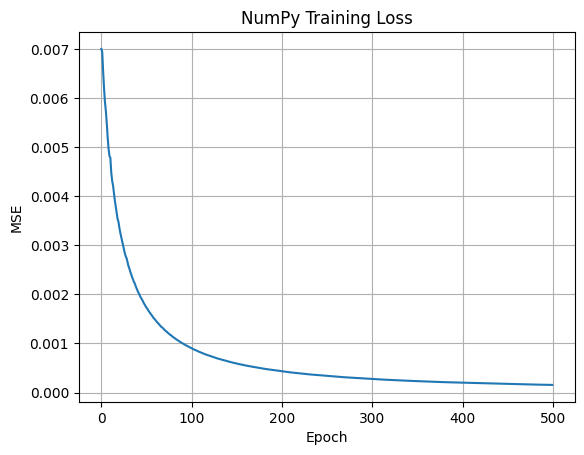

Final XOR preds: [0. 1. 1. 0.]
Accuracy: 1.0


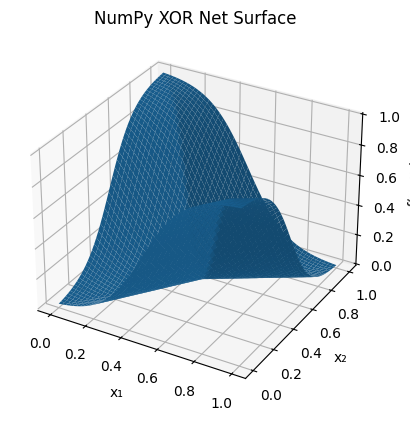

In [35]:
# ─── 6) TRAINING LOOP ────────────────────────────────────────
lr, epochs = 1.5, 500
loss_hist = []

for _ in range(epochs):
    Z1, A1, Z2, A2 = forward(X, W1, b1, W2, b2)

    # backward
    dZ2 = (A2 - Y) * sigmoid_deriv(Z2)      # (4×1)
    dW2 = A1.T @ dZ2                        # (32×4)@(4×1) → (32,1)
    db2 = dZ2.sum(axis=0)                   # (1,)

    dA1 = dZ2 @ W2.T                        # (4×1)@(1×32) → (4,32)
    dZ1 = dA1 * relu_deriv(Z1)              # (4×32)
    dW1 = X.T @ dZ1                         # (2×4)@(4×32) → (2,32)
    db1 = dZ1.sum(axis=0)                   # (32,)

    # updates
    W2 -= lr * dW2;  b2 -= lr * db2
    W1 -= lr * dW1;  b1 -= lr * db1

    loss_hist.append(mse(A2, Y))

# ─── 7) PLOT LOSS & ACCURACY ────────────────────────────────
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("NumPy Training Loss")
plt.grid(True)
plt.show()

preds = predict(X)
acc = np.mean(preds == Y.squeeze())
print("Final XOR preds:", preds)
print("Accuracy:", acc)

# ─── 8) SURFACE PLOT ─────────────────────────────────────────
grid = 50
xs = np.linspace(0,1,grid); ys = np.linspace(0,1,grid)
Xg,Yg = np.meshgrid(xs,ys)
pts = np.column_stack([Xg.ravel(), Yg.ravel()])
Zg  = forward(pts, W1, b1, W2, b2)[3].reshape(Xg.shape)

fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
ax.plot_surface(Xg, Yg, Zg)
ax.set_xlabel('x₁'); ax.set_ylabel('x₂'); ax.set_zlabel('f(x₁,x₂)')
ax.set_title('NumPy XOR Net Surface')
plt.show()

In [36]:
def forward(X, W1, b1, W2, b2):
    Z1 = X @ W1     + b1      # (batch, input) @ (input, hidden) → (batch, hidden)
    A1 = relu(Z1)
    Z2 = A1 @ W2     + b2     # (batch, hidden) @ (hidden, output) → (batch, output)
    A2 = sigmoid(Z2)
    return Z1, A1, Z2, A2

In [37]:
def mse(y_pred, y_true):
    return np.mean((y_true - y_pred.squeeze())**2)

In [38]:
lr = 1.5
epochs = 500
loss_history = []



for epoch in range(epochs):
    # 1) W1: (input_dim, hidden_dim), b1: (hidden_dim,)
    # 2) W2: (hidden_dim, output_dim), b2: (output_dim,)


    # forward
    Z1 = X @ W1 + b1
    A1 = relu(Z1)
    Z2 = A1 @ W2    + b2
    A2 = sigmoid(Z2)

    # backward
    dZ2 = A2 - Y                         # (batch, output)
    dW2 = A1.T @ dZ2                     # (hidden, output)
    db2 = dZ2.sum(axis=0)                # (output,)

    # inside your training loop, just before dA1
    #print("dZ2:", dZ2.shape, "  W2:", W2.shape, "  W2.T:", W2.T.shape)
    dA1 = dZ2 @ W2.T

    dA1 = dZ2 @ W2.T                     # (batch, hidden)
    dZ1 = dA1 * relu_derivative(Z1)      # (batch, hidden)
    dW1 = X.T @ dZ1                      # (input, hidden)
    db1 = dZ1.sum(axis=0)                # (hidden,)

    # updates
    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2


    loss = mse(A2, Y)
    loss_history.append(loss)


In [39]:
def predict(X):
    _, _, _, A2 = forward(X, W1, b1, W2, b2)
    return np.round(A2).squeeze()

preds = predict(X)
accuracy = np.mean(preds == Y)
print("Accuracy:", accuracy)
for i in range(4):
    print(f"XOR({X[i,0]}, {X[i,1]}) = {int(preds[i])}")

Accuracy: 0.5
XOR(0, 0) = 0
XOR(0, 1) = 1
XOR(1, 0) = 1
XOR(1, 1) = 0


0.48795380841040925


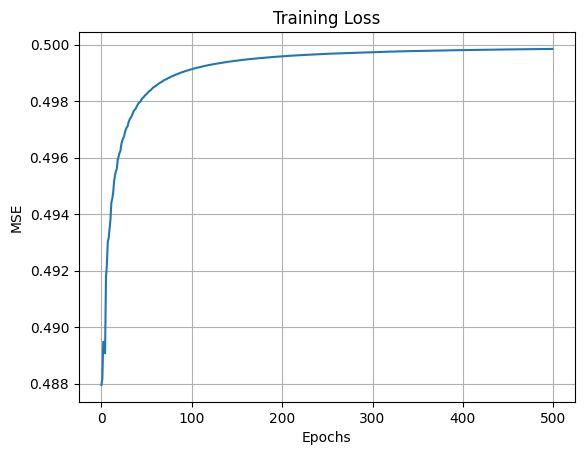

In [40]:
print(loss_history[0])
plt.plot(loss_history)
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Training Loss")
plt.grid(True)
plt.show()

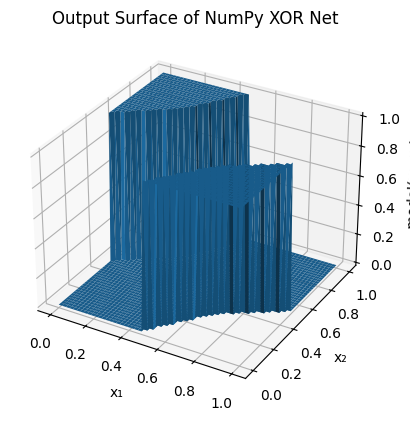

In [41]:
# 1) Build a grid over [0,1]×[0,1]
grid_size = 50
x_vals = np.linspace(0, 1, grid_size)
y_vals = np.linspace(0, 1, grid_size)
Xg, Yg = np.meshgrid(x_vals, y_vals)

# 2) Run the model on every grid point
pts = np.column_stack([Xg.ravel(), Yg.ravel()])     # shape (grid_size², 2)
Zg = predict(pts).reshape(Xg.shape)       # back to (grid_size, grid_size)

# 3) Plot
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
ax.plot_surface(Xg, Yg, Zg, rstride=1, cstride=1)    # default colormap gives the colorbar-like look
ax.set_xlabel('x₁')
ax.set_ylabel('x₂')
ax.set_zlabel('model(x₁, x₂)')
ax.set_title('Output Surface of NumPy XOR Net')
plt.show()

## 1.6. TensorFlot comparison

I will now try to implement the same function but in tensorflow. I used the same approach as the example used and just copy pasted all of the data and built it using keras and just plotted the surface plot and the MSE convergence.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Initial MSE: 0.020888513


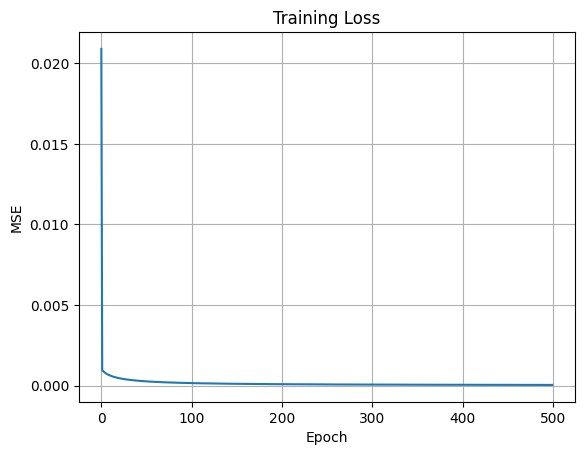

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Final accuracy on XOR: 1.0
XOR(0,0) → 0
XOR(0,1) → 1
XOR(1,0) → 1
XOR(1,1) → 0


In [42]:
# ─── 1) XOR DATA ────────────────────────────────────────────────
X = np.array([[0,0],
              [0,1],
              [1,0],
              [1,1]], dtype=np.float32)
Y = np.array([[0],
              [1],
              [1],
              [0]], dtype=np.float32)

# ─── 3) PACK INTO KERAS FORMAT ─────────────────────────────────
# Keras Dense kernels are shape (input_dim, units)
W1 = np.stack([w11, w12], axis=0)     # → shape (2,32)
b1 = b1                               # → shape (32,)

W2 = ws2[:32].reshape((32,1))         # → shape (32,1)
b2 = ws2[32:].reshape((1,))           # → shape (1,)

# ─── 4) BUILD & INJECT ─────────────────────────────────────────
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(2,), use_bias=True),
    tf.keras.layers.Dense(1,  activation='sigmoid',    use_bias=True)
])

# overwrite the randomly‐initialized weights:
model.layers[0].set_weights([W1, b1])
model.layers[1].set_weights([W2, b2])

# ─── 5) CHECK INITIAL LOSS ─────────────────────────────────────
pred0 = model.predict(X)
init_mse = np.mean((pred0 - Y)**2)
print("Initial MSE:", init_mse)   # should be ≈0.2284

# ─── 6) TRAIN EXACTLY AS BEFORE ─────────────────────────────────
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1.5),
    loss='mse'
)
history = model.fit(X, Y, epochs=500, verbose=0)

# ─── 7) PLOT & EVALUATE ─────────────────────────────────────────
plt.plot(history.history['loss'])
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training Loss")
plt.grid(True)
plt.show()

pred_final = (model.predict(X) > 0.5).astype(int)
acc = np.mean(pred_final == Y)
print("Final accuracy on XOR:", acc)
for xi, pi in zip(X, pred_final.squeeze()):
    print(f"XOR({int(xi[0])},{int(xi[1])}) → {pi}")


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


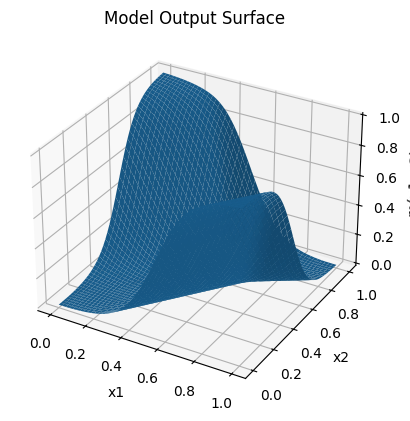

In [43]:
# 1) build a grid of (x1, x2) pairs over [0,1]
grid_size = 50
x_vals = np.linspace(0, 1, grid_size)
y_vals = np.linspace(0, 1, grid_size)
Xg, Yg = np.meshgrid(x_vals, y_vals)

# 2) predict on every point
pts = np.column_stack([Xg.ravel(), Yg.ravel()])
Zg = model.predict(pts).ravel().reshape(Xg.shape)

# 3) plot the surface
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
ax.plot_surface(Xg, Yg, Zg)    # uses default colormap
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('m(x1, x2)')
ax.set_title('Model Output Surface')
plt.show()